In [72]:
from IPython.display import display
import pandas as pd 
import pandas as pd
from scipy.stats import ttest_ind, chi2_contingency, f_oneway, kruskal
import matplotlib.pyplot as plt
import seaborn as sns

# Define the path to the new Parquet file
parquet_file = "C:/Users/matsbosma/Documents/TMall/TMall.parquet"

# Load the data from the Parquet file
df = pd.read_parquet(parquet_file)

# Display the first few rows of the data
display(df.head(10))  # Using display for better formatting

# check how many rows and columns are in the data
print(df.shape)




,SSID,user_session,session,visitorid,timestamp,itemid,event,event_duration,events_per_session,PageTime,...,time_since_last_view,time_since_last_ATC,time_since_last_purchase,time_since_last_event,TimeOfDay,WeekdayVsWeekend,Month,Season,ATC,Purchase
1092725,201308271734260100000055339,1000000_0,0,1000000,2013-08-27 17:34:00.626,55339,2,260.718177,1,260.718177,...,0.000,0.0,0.0,0.000,1,0,8,2,0,0
1942407,2013052416242601000001320115,1000001_0,0,1000001,2013-05-24 16:24:31.738,320115,2,260.718177,1,260.718177,...,0.000,0.0,0.0,0.000,1,0,5,1,0,0
1073483,2013082622502601000002376356,1000002_0,0,1000002,2013-08-26 22:50:57.216,376356,2,260.718177,1,260.718177,...,0.000,0.0,0.0,0.000,2,0,8,2,0,0
837287,2013081308262601000003422529,1000003_0,0,1000003,2013-08-13 08:26:28.112,422529,2,260.718177,1,260.718177,...,0.000,0.0,0.0,0.000,0,0,8,2,0,0
324990,2013061702082601000007300114,1000007_0,0,1000007,2013-06-17 02:08:42.130,300114,2,260.718177,1,260.718177,...,0.000,0.0,0.0,0.000,3,0,6,2,0,0
338748,201306172114260100000199143,100000_0,0,100000,2013-06-17 21:14:54.874,199143,2,260.718177,1,260.718177,...,0.000,0.0,0.0,0.000,2,0,6,2,0,0
599297,201306302229260100001236163,1000012_0,0,1000012,2013-06-30 22:29:10.413,36163,2,260.718177,1,260.718177,...,0.000,0.0,0.0,0.000,2,1,6,2,0,0
1908377,2013052517382701000013247755,1000013_0,0,1000013,2013-05-25 17:38:09.210,247755,2,9.962000,2,9.962000,...,0.000,0.0,0.0,0.000,1,1,5,1,0,0
1913606,2013052517382701000013238720,1000013_0,0,1000013,2013-05-25 17:38:19.172,238720,2,260.718177,2,270.680177,...,9.962,0.0,0.0,9.962,1,1,5,1,0,0
2012869,201305292318260100001360403,1000013_1,1,1000013,2013-05-29 23:18:09.823,60403,2,260.718177,1,260.718177,...,0.000,0.0,0.0,0.000,2,0,5,1,0,0


(1196087, 33)


In [73]:
# Define the continuous columns
continuous_columns = ['PageTime', 'time_since_last_ATC', 'time_since_last_purchase', 'time_since_last_event', 'event_duration', 'time_since_last_view', 'time_since_last_ATC']
# Create a new column to flag outliers
df['Outlier_Flag'] = 'Inlier'  # Initialize all rows as inliers

# Function to flag outliers based on IQR for each column
def flag_outliers(df, columns):
    for column in columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        # Flag rows where the value in the column is an outlier
        outliers = (df[column] < (Q1 - 1.5 * IQR)) | (df[column] > (Q3 + 1.5 * IQR))
        df.loc[outliers, 'Outlier_Flag'] = 'Outlier'
    return df

# Apply the function
df = flag_outliers(df, continuous_columns)

# Check the distribution of flagged inliers and outliers
print(df['Outlier_Flag'].value_counts())


Outlier_Flag
Inlier     853981
Outlier    342106
Name: count, dtype: int64


In [74]:
# Separate the data into inliers and outliers
df_outliers = df[df['Outlier_Flag'] == 'Outlier']
df_inliers = df[df['Outlier_Flag'] == 'Inlier']


In [75]:
# Convert timestamp to datetime format
df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')


In [76]:
# Extract the hour from timestamp
df['Hour'] = df['timestamp'].dt.hour


In [77]:
# Define time of day categories based on the hour
def categorize_time_of_day(hour):
    if 6 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 18:
        return 'Afternoon'
    elif 18 <= hour < 24:
        return 'Evening'
    else:
        return 'Night'

# Apply the categorization function to the Hour column
df['TimePeriod'] = df['Hour'].apply(categorize_time_of_day)


In [78]:
# Check the unique values in TimePeriod
print(df['TimePeriod'].unique())


['Afternoon' 'Evening' 'Morning' 'Night']


In [79]:
# Calculate purchase rate for each time period
purchase_rate_by_time = df.groupby('TimePeriod')['Purchase'].mean()

# Display purchase rates
print("Purchase Rate by Time of Day:")
print(purchase_rate_by_time)


Purchase Rate by Time of Day:
TimePeriod
Afternoon    0.000968
Evening      0.001053
Morning      0.000613
Night        0.000738
Name: Purchase, dtype: float64


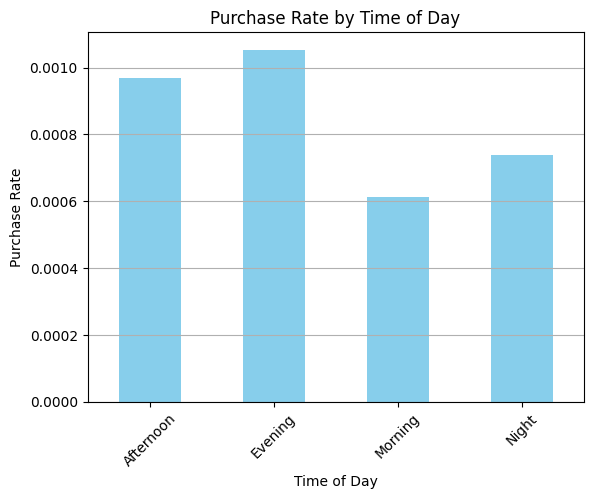

In [80]:
# Plot purchase rates
purchase_rate_by_time.plot(kind='bar', color='skyblue')
plt.title('Purchase Rate by Time of Day')
plt.xlabel('Time of Day')
plt.ylabel('Purchase Rate')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()


**Null Hypothesis: Purchase rates are the same across different times of day**

P-Value Interpretation:

The p-value of 0.3758 is much higher than the common significance threshold (typically 0.05). This means that we fail to reject the null hypothesis.
In this context, failing to reject the null hypothesis suggests that there is no statistically significant association between the time of day and the likelihood of making a purchase.
Conclusion:

Based on this analysis, we conclude that purchases are likely to be evenly distributed across different times of the day. There is no strong evidence to suggest that purchases are more likely to happen during any particular time period (Morning, Afternoon, Evening, or Night).
Implications:

Since the time of day does not appear to influence purchase behavior, it might not be a valuable factor for segmenting users or targeting marketing efforts specifically by time of day.

In [81]:
from scipy.stats import chi2_contingency

# Create a contingency table for TimePeriod and Purchase
contingency_table = pd.crosstab(df['timestamp'], df['Purchase'])

# Perform the Chi-Square test
chi2, p, dof, expected = chi2_contingency(contingency_table)

# Display the results
print("Chi-Square Test Results for Purchase by Time of Day:")
print(f"Chi-square statistic: {chi2:.4f}")
print(f"P-value: {p:.4f}")


Chi-Square Test Results for Purchase by Time of Day:
Chi-square statistic: 1196087.0000
P-value: 0.3758


**Null Hypothesis: The average session duration is the same across all hours of the day. In other words, the time of day has no effect on session duration.**

P-Value Interpretation:

The p-value is 0.0, which is less than the common significance level of 0.05.
A p-value this low indicates that we can reject the null hypothesis with a high degree of confidence.
Conclusion:

Reject the null hypothesis. This means that there is a statistically significant difference in average session duration across different hours of the day.
This suggests that session duration varies by hour, indicating that users may stay on the site for longer periods during certain hours.
Implications:

The chart shows that session duration is generally higher in the early morning hours (0 to 12) and decreases sharply in the afternoon.
Understanding these patterns could help with operational decisions, such as scheduling peak resources during hours with longer session durations or targeting specific hours for user engagement activities.

ANOVA result for hours: F-statistic = 333.26327115413443, p-value = 0.0


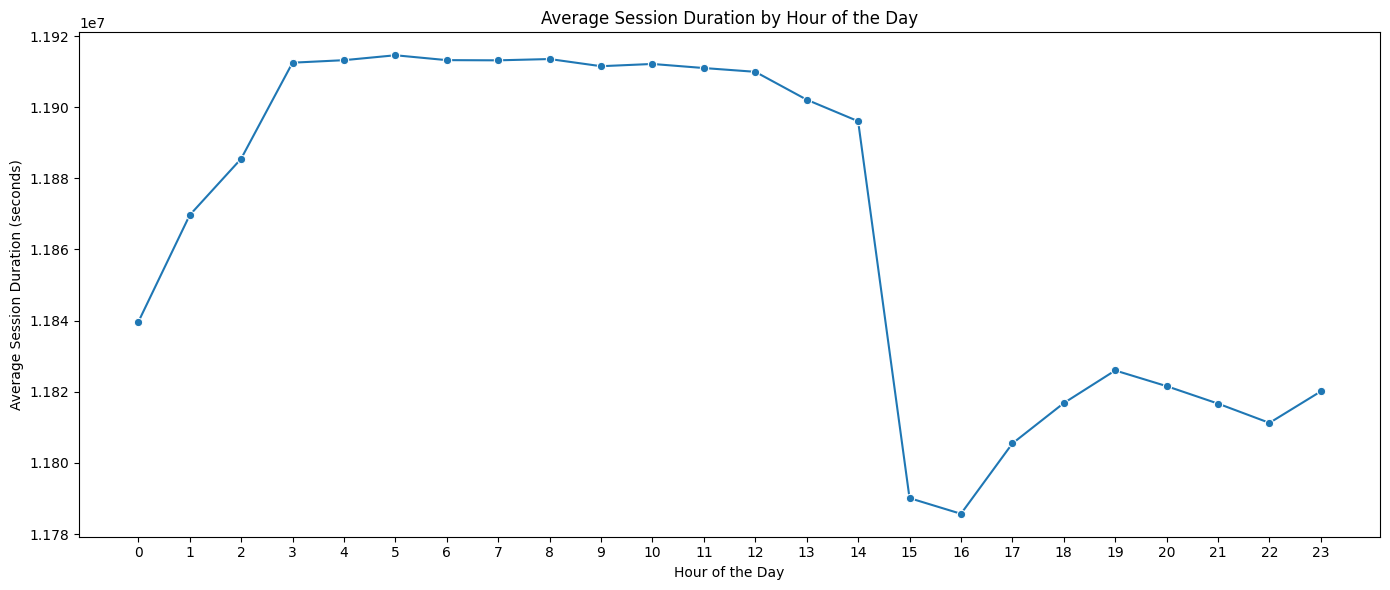

In [82]:
# Ensure the necessary columns are present
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Extract the hour of the day and day of the week from the timestamp
df['hour'] = df['timestamp'].dt.hour
df['day_of_week'] = df['timestamp'].dt.dayofweek

# Create a feature for session duration (assuming 'session' column exists)
df['session_duration'] = df.groupby('session')['timestamp'].transform(lambda x: (x.max() - x.min()).total_seconds())

# Remove outliers based on session duration (e.g., remove top 1% of session durations)
session_duration_threshold = df['session_duration'].quantile(0.99)
df = df[df['session_duration'] <= session_duration_threshold]

# Aggregate session durations by hour of the day
hourly_session_duration = df.groupby('hour')['session_duration'].mean().reset_index()

# Aggregate session durations by day of the week
daily_session_duration = df.groupby('day_of_week')['session_duration'].mean().reset_index()

# Perform ANOVA to compare session durations across hours of the day
anova_result_hour = f_oneway(
    *[df[df['hour'] == hour]['session_duration'].dropna() for hour in df['hour'].unique()]
)

print(f"ANOVA result for hours: F-statistic = {anova_result_hour.statistic}, p-value = {anova_result_hour.pvalue}")

# Visualization

# Visualization of session duration by hour of the day
plt.figure(figsize=(14, 6))
sns.lineplot(data=hourly_session_duration, x='hour', y='session_duration', marker='o')
plt.title('Average Session Duration by Hour of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Average Session Duration (seconds)')
plt.xticks(range(0, 24))
plt.tight_layout()
plt.show()
